# Yandex Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


In [51]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_rel
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [52]:
X, y = load_boston(return_X_y=True)
print(f'p = {X.shape[1]}')
print(f'n = {X.shape[0]}')

p = 13
n = 506


In [53]:
# * write a model `Ols` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score`.? hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

class Ols(object):
    def __init__(self):
        self.w = None

    @staticmethod
    def pad(X):
        bias = np.ones((X.shape[0], 1))
        return np.hstack((bias, X))

    def fit(self, X, y):
        X = self.pad(X)
        self.w = (np.linalg.pinv(X)@y).reshape(-1,1)

    def predict(self, X):
        X = self.pad(X)
        return X @ self.w

    def score(self, X, y):
        # return MSE
        X = self.pad(X)
        return np.mean(np.square((X @ self.w) - y.reshape(-1,1)))

In [54]:
regressor = Ols()
regressor.fit(X, y)
predictions = regressor.predict(X)
mse = regressor.score(X,y)
print(f'Training MSE: {mse}')

Training MSE: 21.894831181729202


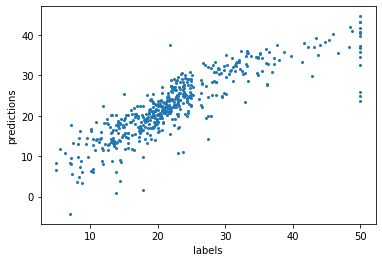

In [55]:
plt.scatter(y, predictions,s=4)
plt.xlabel('labels')
plt.ylabel('predictions')
plt.show()

In [56]:
train_mse_vals = []
test_mse_vals = []
rs = ShuffleSplit(n_splits=20, test_size=.25, random_state=42)

for train_index, test_index in rs.split(X):
    reg = Ols()
    reg.fit(X[train_index], y[train_index])
    train_mse_vals.append(reg.score(X[train_index], y[train_index]))
    test_mse_vals.append(reg.score(X[test_index], y[test_index]))

train_mse = np.array(train_mse_vals).mean()
test_mse = np.array(test_mse_vals).mean()
print(f'Average train MSE: {train_mse}')
print(f'Average test MSE: {test_mse}')

Average train MSE: 21.193933513766574
Average test MSE: 25.507532313919487


In [57]:
pval = ttest_rel(train_mse_vals, test_mse_vals).pvalue
print(f'P-value for t-test for similarity between train and test MSE: {pval}')

P-value for t-test for similarity between train and test MSE: 0.03144792965188967


* Since p-value is ~3%, we reject the null hypothesis that the train and test sets have an equal mean with 5% confidence. 

In [58]:
# Write a new class OlsGd which solves the problem using gradinet descent. 
# The class should get as a parameter the learning rate and number of iteration. 
class Normalizer():

    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, X):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)

    def predict(self, X):
        # apply normalization
        return (X - self.means) / self.stds


class OlsGd(Ols):

    def __init__(self, learning_rate=.05,
                 num_iteration=1000,
                 normalize=True,
                 early_stop=True,
                 verbose=True):
        super(OlsGd, self).__init__()
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        self.early_stop = early_stop
        self.normalize = normalize
        self.normalizer = Normalizer()
        self.verbose = verbose

    def fit(self, X, Y, reset=True, track_loss=True):
        self.normalizer.fit(X)
        X = self.normalizer.predict(X)
        X = self.pad(X)
        self.w = np.zeros((X.shape[1], 1))
        loss_vals = []

        for i in range(self.num_iteration):
            self.step(X, y)
            loss = np.mean(np.square((X @ self.w) - y.reshape(-1,1)))
            loss_vals.append(loss)

        return loss_vals

    def predict(self, X):
        X = self.normalizer.predict(X)
        X = self.pad(X)
        return X @ self.w

    def step(self, X, Y):
        # use w update for gradient descent
        self.w = self.w - 2 * self.learning_rate * ((X.T @ ((X @ self.w) - y.reshape(-1, 1))) / X.shape[0])

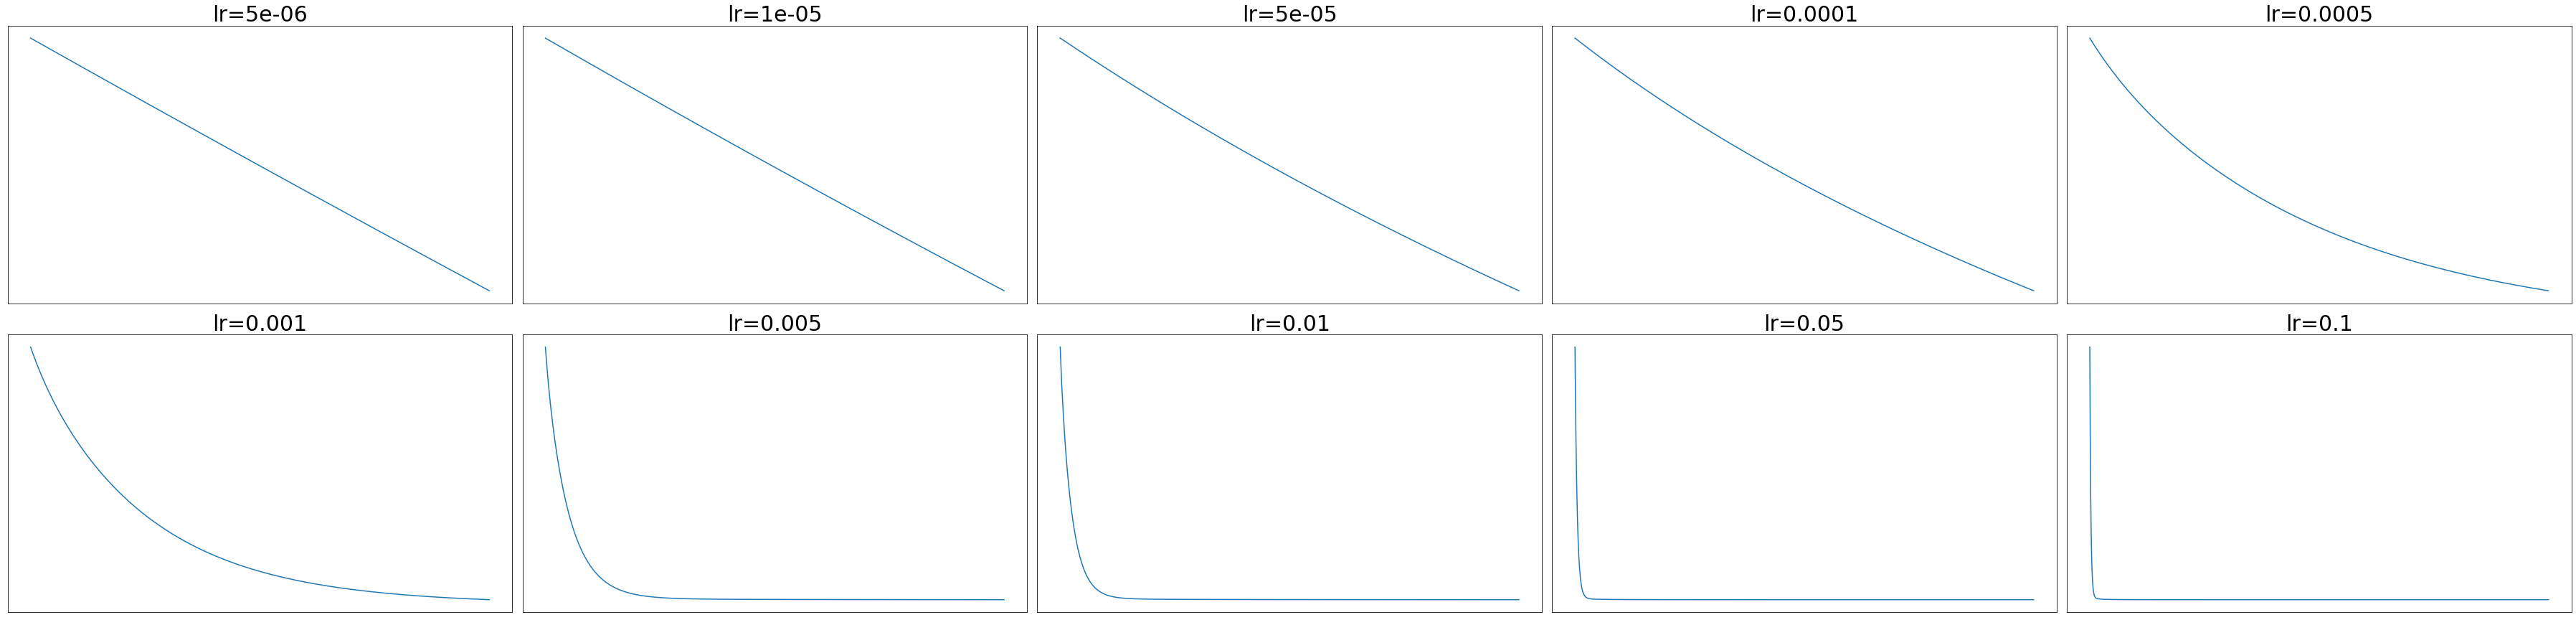

In [59]:
# Plot the loss convergance. for each alpha, learning rate plot the MSE with respect to number of iterations.
alpha_vals = [5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
plt.figure(figsize=(50, 30))

for i, alpha in enumerate(alpha_vals):
    regressor = OlsGd(learning_rate=alpha)
    loss_vals = regressor.fit(X, y)
    plt.subplot(5, 5, i+1)
    plt.plot(loss_vals)
    plt.xticks(())
    plt.yticks(())
    plt.title(f'lr={alpha}', size=30)

plt.tight_layout()
plt.show()


In [60]:
# What is the effect of learning rate? 
# How would you find number of iteration automatically? 
# Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your feature first.

#### Answers
* As we can observe in the graphs shown above, the larger the learning rate, the faster the loss converges (there is also a case where the lr is too large and the loss doesnt converge).  
* We can see that for learning rates that converge (the bottom row), there is always a point where the loss stays almost constant and doesn't decrease any more, the iterations after this point do not improve our model and even lead to overfitting. For this reason it will be helpful to limit the number of iterations - a proposed method is to stop the algorithm when the decrease in loss is lower than a specified threshold.
* If features are not normalized, the gradient will descend fastest in the directions of features with a higher range of values and slower in features with a lower range of values. This can lead to slower convergance and getting stuck in a local minimum of the loss function.

In [61]:
#On the test data plot the for each of the methods Ols, OlsGD, and OlsCD plot the MSE with respect to the iterations
class OlsCd(Ols):
  """coordinate descent"""
  
  def __init__(self, 
               num_iteration=10, 
               verbose=True):
    super(OlsCd, self).__init__()
    self.num_iteration = num_iteration
    self.verbose = verbose
    self.loss = []
    
  def _fit(self, X, Y, reset=True, track_loss=True):
    pass
          
  def _step(self, X, Y):
    #Coordinate gradient descent step for the single dimension 
    pass

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation? 



#### Derivation of Ridge regression analytical solution
* Write the prediction in terms of the data and parameters and explicitly write the L2 size of w:
 \begin{array}{l}
\sum ^{n}_{i=1} (y_{i} -x^{T}_{i} w)^{2} +\lambda \sum ^{p}_{j=1} w^{2}_{j}\\
\end{array}
* Write in matrix notation and develop the equation:
 \begin{array}{l}
(y-Xw)^{T} (y-Xw)+\lambda w^{T} w\\
=y^{T} y-2^{T} X^{T} y-y^{T} Xw+w^{T} x^{T} Xw+\lambda w^{T} w\\
=y^{T} y-w^{T} X^{T} y-w^{T} X^{T} y+w^{T} X^{T} Xw+w^{T} \lambda Iw\\
=y^{T} y-2w^{T} X^{T} y+w^{T} (X^{T} X+\lambda I)w
\end{array}
* Take derivative and compare to 0 to find minimum:
 \begin{array}{l}
\frac{\partial Loss_{Ridge}}{\partial w} =-2X^{T} y+2(X^{T} X+\lambda I)w\ =\ 0\\
(X^{T} X+\lambda I)w=X^{T} y\\
\hat{w} =(X^{T} X+\lambda I)^{-1} X^{T} y
\end{array}

In [62]:
class RidgeLs(Ols):
    def __init__(self, ridge_lambda, *wargs, **kwargs):
        super(RidgeLs, self).__init__(*wargs, **kwargs)
        self.ridge_lambda = ridge_lambda

    def fit(self, X, y):
        X = self.pad(X)
        identity = np.ones((X.shape[1], X.shape[1]))
        self.w = (np.linalg.inv(X.T@X + self.ridge_lambda * identity)@X.T @ y).reshape(-1, 1)

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [71]:
# compare ols, ridge regression and lasso regression
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
predictions = []
scores = []

for deg in degrees:
    poly = PolynomialFeatures(deg)
    X_train = poly.fit_transform(X.reshape(-1,1))
    X_test = np.linspace(0,1,100)
    X_test = poly.transform(X_test.reshape(-1,1))
    model_1 = LinearRegression()
    model_1.fit(X_train, y)
    model_2 = RidgeCV()
    model_2.fit(X_train, y)
    model_3 = LassoCV()
    model_3.fit(X_train, y)
    predictions.append([model_1.predict(X_test), model_2.predict(X_test), model_3.predict(X_test)])
    score_1 = -cross_val_score(model_1, X_train, y, scoring='neg_mean_squared_error').mean()
    score_2 = -cross_val_score(model_2, X_train, y, scoring='neg_mean_squared_error').mean()
    score_3 = -cross_val_score(model_3, X_train, y, scoring='neg_mean_squared_error').mean()
    scores.append([score_1, score_2, score_3])


/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00042337488572846693, tolerance: 0.00021764388220146157
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021421101787039154, tolerance: 0.00021764388220146157
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003499168792955476, tolerance: 0.00021764388220146157
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: Convergen

/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011008417376951463, tolerance: 0.001076863302096056
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011681760630933014, tolerance: 0.001076863302096056
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011298612199437952, tolerance: 0.001076863302096056
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarn

/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003156051646105995, tolerance: 0.00016315652322765702
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003417760308883355, tolerance: 0.00016315652322765702
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037004628141201756, tolerance: 0.00016315652322765702
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: Converge

/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020150637905247404, tolerance: 0.00018615907537779367
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019768965410866812, tolerance: 0.00018615907537779367
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016016919034682608, tolerance: 0.0010859320466406945
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: Convergen

/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012618998106513346, tolerance: 0.0010394670885084268
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014223385074035866, tolerance: 0.0010394670885084268
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014953336156440789, tolerance: 0.0010394670885084268
  tol, rng, random, positive)
/home/uri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceW

In [72]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame(np.array(scores), index=[degrees], columns=['Linear', 'Ridge', 'Lasso'])

,Linear,Ridge,Lasso
1,1.003,0.862,0.933
4,5.745,0.313,0.196
15,1130644340615337.750,0.369,0.306


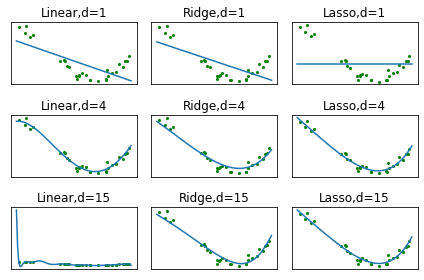

In [73]:
fig, axes = plt.subplots(3,3)

for i in range(3):
    for j, name in enumerate(['Linear', 'Ridge', 'Lasso']):
        axes[i][j].plot(np.linspace(0,1,100), predictions[i][j])
        axes[i][j].scatter(X, y, s=4, c='g')
        axes[i][j].set_xticks(())
        axes[i][j].set_yticks(())
        axes[i][j].set_title(f'{name},d={degrees[i]}')

plt.tight_layout()
plt.show()


* The table above compares the cross validated MSE values between the models for each degree of polynomial.  
* We can see that for 1st and 4th degrees, the MSE values are similar across models, and for the 1st degree all models have a higher error than for 4th degree. These 2 degrees represent an underfitted model and a "just right" (although slightly overfitted) model, respectively.  
* For polynomial of 15th degree, we see that the error has exploded for the linear regression model but has stayed almost the same for the ridge and lasso regression models. This degree represents an overfitted model.  
* The take home message for us here is that models that apply regularization have the biggest advantage when using high dimensional data that is prone for overfitting. In cases of underfitting or data dimension that is "just right", the regularized models might not improve the error.

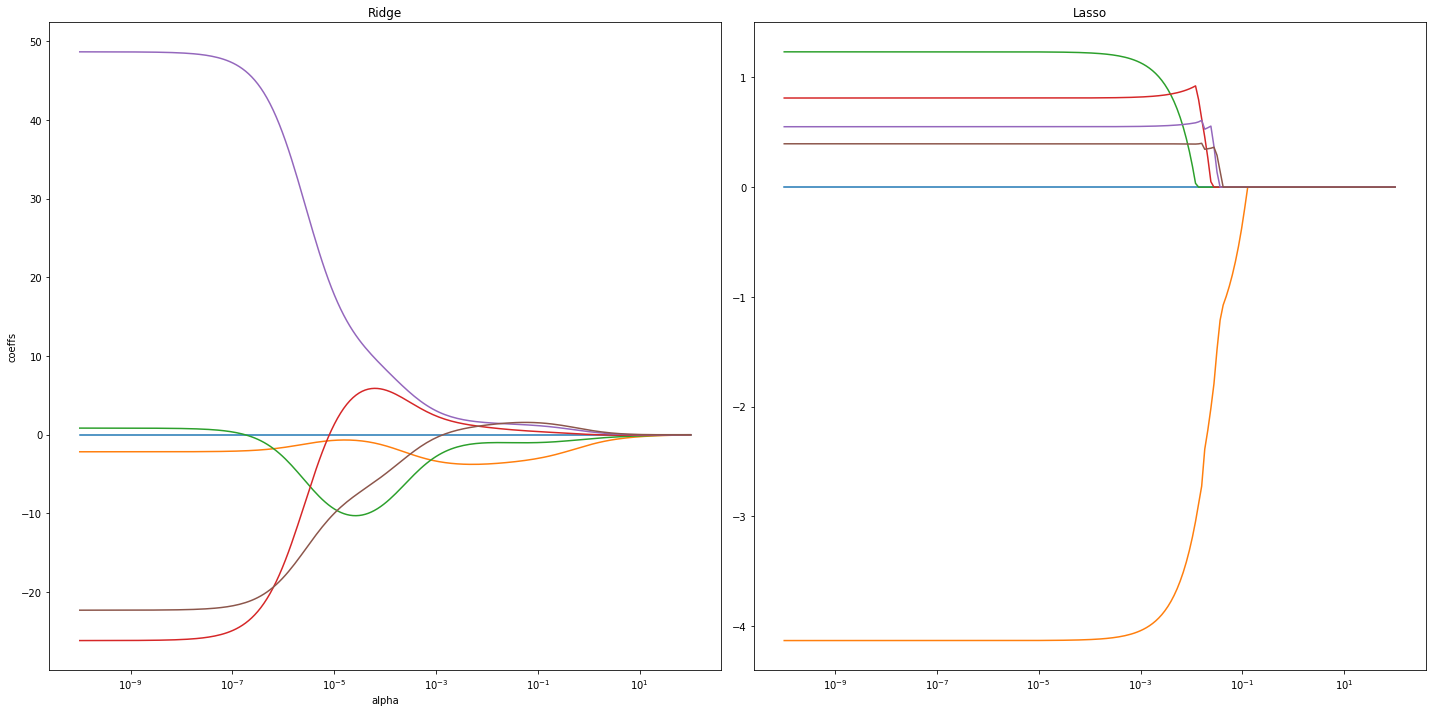

In [87]:
# weights spectrum
n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)

ridge_coeffs = []
lasso_coeffs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, tol=0.1)
    lasso = Lasso(alpha=alpha, tol=0.1)
    poly = PolynomialFeatures(5)
    X_train = poly.fit_transform(X.reshape(-1,1))
    ridge.fit(X_train, y)
    lasso.fit(X_train, y)
    ridge_coeffs.append(ridge.coef_)
    lasso_coeffs.append(lasso.coef_)

fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].plot(alphas, ridge_coeffs)
axes[0].set_xscale('log')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('coeffs')
axes[0].set_title('Ridge')
axes[1].plot(alphas, lasso_coeffs)
axes[1].set_xscale('log')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('coeffs')
axes[1].set_title('Lasso')
plt.tight_layout()
plt.show()

* From the plots above, we can see that both for ridge and for lasso regression, when the regularization parameter grows, the size of all coefficients diverges to zero, although lasso coefficients converge to zero faster.
* The reason for this is that when alpha is very large, the regularization effect dominates the squared loss function and the coefficients tend to zero, when it is infinitely small, no regularization is in place and the model converges to an ols model.